In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import sys

from Bio import SeqIO
from datetime import datetime

from torch.utils import data
#from data_generator import data_generator
from data_generator import Dataset
from lstm import LSTM_model
from lstm import LSTMCell
from alpha_set import alpha_set
from print_seq import print_seq

In [2]:
#acids = "abcdefghijklmnopqrstuvwxyz-"
acids = "ACDEFGHIKLMNOPQRSTUVWY-"
large_file = "uniref50.fasta"
small_file = "100k_rows.fasta"
test_file = "test.fasta"

#max_seq_len = 50
#max_seq_len = 2000
max_seq_len = 500

# Good sizes: 16/700 or 32/400 on laptop
# 32/1500 on desktop
batch_size = 32
hidden_dim = 200

hidden_layers = 2

# Use Cuda if available
use_cuda = torch.cuda.is_available() and True
print("Using GPU:", use_cuda)
processor = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


# Initialising data generator
dataset = Dataset(small_file, max_seq_len, acids=acids)
#dataset = alpha_set(acids, max_seq_len, 3200)
base_generator = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialising for training
model = LSTM_model(len(acids), hidden_dim, hidden_layers, max_seq_len, batch_size, processor).to(processor)
loss_function = nn.CrossEntropyLoss(reduction="mean").to(processor)
optimiser = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, nesterov=True)

# Best lr so far is 2e-2
#optimiser = optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

Using GPU: True


In [ ]:
# Initialising some variables for use in training
batches = 1000
time_diff = 0
no_improv = 0
min_loss = float("inf")
loss_list = []
epochs = 1
print_stuff = True

# Main training loop
for epoch in range(epochs):
    for i, (batch, labels, valid_elems) in enumerate(base_generator):

        # Keeping track of stuff
        start_time = datetime.now()
        sys.stdout.write("\rBatch: {0}. Min loss: {1:.5f}. Estimated time left: {2}. Batches since improvement: {3}.".format(i+1, min_loss, time_diff*(batches - i), no_improv))

        # Putting data on gpu
        batch = batch.to(processor)
        labels = labels.to(processor)
        valid_elems = valid_elems.to(processor)

        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        batch = batch.transpose(0, 1)

        # Resetting gradients
        model.train()
        model.zero_grad()
    
        if i == 0 and print_stuff:
            print("Input:\t", batch.size())
            print("Labels:\t", labels.size())
            print("Valid:\t", valid_elems)

        batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)
        labels = rnn.pack_padded_sequence(labels, valid_elems, enforce_sorted=False, batch_first=True)

        out, hidden = model(batch)
        
        out = rnn.pack_padded_sequence(out, valid_elems, enforce_sorted=False)
        if i == 0 and print_stuff:
            print("Output:\t", out.data.size())
            print("Hidden:\t", hidden.data.size())


        #print(out.data.size())
        #print(labels.data.size())
        loss = loss_function(out.data, labels.data)
    
        '''
        # This bit is replaced by packing labels and the line above
        # Backpropping only through the non-padded parts
        loss = 0
        for j in range(out.size()[1]):
        #print(out.size())
        #print(torch.narrow(out, 1, j, 1).squeeze(1).size())
        
        narrowed_out = torch.narrow(torch.narrow(out, 1, j, 1).squeeze(1), 0, 0, valid_elems[j])
        narrowed_labels = torch.narrow(labels[j], 0, 0, valid_elems[j])

        #print_seq(narrowed_out[0].view(1,2000,23))
        
        print(narrowed_out.size())
        print(narrowed_labels.size())
        loss += loss_function(narrowed_out, narrowed_labels)
        '''
        #loss /= out.size()[1]

        loss_list.append(loss.item())
        loss.backward()
        optimiser.step()

        if loss.item() < min_loss:
            torch.save(model.state_dict(), "model.pth")
            min_loss = loss.item()
            no_improv = 0
        else:
            no_improv += 1
        
    
    
        # For tracking progress
        end_time = datetime.now()
        time_diff = end_time - start_time
    
        # Breaking when it's run through the given number of batches
        if i+1 >= batches:
            break

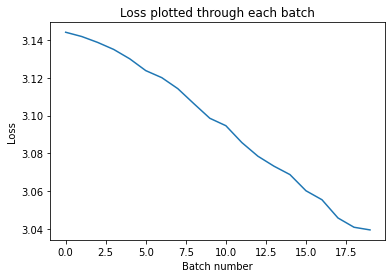

In [4]:
# Plotting the loss through the epochs
plt.plot(loss_list)
#plt.scatter(range(len(loss_list)), loss_list)
plt.title("Loss plotted through each batch")
plt.ylabel("Loss")
plt.xlabel("Batch number")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("loss_log.png")

In [5]:
# Predicting
accuracies = []
with torch.no_grad():
    # Loading saved model from file
    model.load_state_dict(torch.load("model.pth"))
    #model.eval()

    # Initalising data generator
    #dataset = Dataset(small_file, max_seq_len, acids=acids)
    #base_generator = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

    correct = 0
    
    # For loops is easiest way to get an element from
    # the generator even though we only loop once
    for i, (batch, labels, valid_elems) in enumerate(base_generator):
        test = batch
        batch = batch.to(processor)
        labels = labels.to(processor)

        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        batch = batch.transpose(0,1)
        #labels = torch.transpose(labels, 0, 1)

        batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)

        out, hidden = model(batch)

        out = out.transpose(0,1)

        print(out.size())
        print(valid_elems.size())
        for j in range(batch_size):
            preds = torch.argmax(out[j], dim=1)[:valid_elems[j]]
            actual = labels[j][:valid_elems[j]]
            truths = [1 if pred == truth else 0 for pred, truth in zip(preds, actual)]
            correct += sum(truths)
        accuracy = correct/(torch.sum(valid_elems).item())
        break
    
print("Test Accuracy: {0:.3f}%".format(accuracy*100))
print(labels.size())

#print(torch.argmax(out[0], dim=1))
#print(torch.max(out[0,:10], dim=1))
#print(torch.argmax(out[0,:10], dim=1))
#print(out[0,:10])

print("\nPredictions")
print_seq(out[0].view(1,out.size()[1], out.size()[2]), valid_elems, acids)
print("\nInput")
print_seq(test[0].view(1,test.size()[1], test.size()[2]), valid_elems, acids)

print_labels = ""
for elem in labels[0][:valid_elems[0]]:
    print_labels += acids[elem]

print("\nLabels", print_labels)

#print_seq(out, valid_elems)


torch.Size([32, 500, 23])
torch.Size([32])


Test Accuracy: 9.798%
torch.Size([32, 500])

Predictions
Sequence 0
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL

Input
Sequence 0
MSATTTEAKQTFLCKERLPRRYHPPSKVLSRLPTSFLPYGELLRLHKPLGYILVCYPFLVAGAFSASIAPEVLEADFWPRITLLCLWSIFLRSGGCIWDDIADQHVDAKVARTRLRPLPRGAVSNSQATIFAAGTFLCGFAFVAELPGVCMVDALIMLFFAVLYPYGKRHSNYPQLILGTIGWAIPMTMHGLNLRPLDHPIPMAAMFAFIALVTIMNDIIYARQDIEEDIKAGVGSMAVRFQHCLDALTFALVFASSAALVIAGKLGNMGAPFFTISVGGHFGFFLFLAMANQRDPKSGVEWAAKRCCTSATFLLIVGMVVDLVWRS-

Labels SATTTEAKQTFLCKERLPRRYHPPSKVLSRLPTSFLPYGELLRLHKPLGYILVCYPFLVAGAFSASIAPEVLEADFWPRITLLCLWSIFLRSGGCIWDDIADQHVDAKVARTRLRPLPRGAVSNSQATIFAAGTFLCGFAFVAELPGVCMVDALIMLFFAVLYPYGKRHSNYPQLILGTIGWAIPMTMHGLNLRPLDHPIPMAAMFAFIALVTIMNDIIYARQDIEEDIKAGVGSMAVRFQHCLDALT